In [27]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account

# from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report
from google.cloud import aiplatform

# Reference
https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [16]:
print(tf.__version__)

2.12.0


In [24]:
#table_id='test_incident'
#table_id='validation_incident'
table_id='new_incident'
#table_id='train_incident'

ENDPOINT_ID="2469916532356939776"
MODEL_ID="2354195132556771328"

isLocalModel=True
isBQToCSV=True
localMapFile=True
gs_store_class="demo2-tf-incident-pongthorn"
gs_model_path="gs://demo2-tf-incident-pongthorn/demo_model_tf"

local_model_path='demo_model_tf'
# ! gsutil -m cp -r "gs://demo2-tf-incident-pongthorn/demo_model_tf" .


modelFile_endPoint=2
#1=local(dev)/gcs(clound function) and 2=endpoint on vertext

# projectId='smart-data-ml'
projectId='pongthorn'
dataset_id='SMartML'
REGION="asia-southeast1"

n_sample_run=0

# mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
bqclient= bigquery.Client(project=projectId)

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='csv_dataset/Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'csv_dataset/Prediction_{table_id}.csv'


In [18]:
if isBQToCSV:
    
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    
  
if n_sample_run>0:
 dfNewData=dfNewData.tail(n_sample_run)
print(dfNewData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         49 non-null     Int64         
 1   severity_id                49 non-null     Int64         
 2   severity_name              49 non-null     object        
 3   sla                        49 non-null     object        
 4   product_type               49 non-null     object        
 5   brand                      49 non-null     object        
 6   service_type               49 non-null     object        
 7   incident_type              49 non-null     object        
 8   open_to_close_hour         49 non-null     float64       
 9   response_to_resolved_hour  49 non-null     float64       
 10  imported_at                49 non-null     datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), float64(2), object(6)
memory usage: 4.4+ 


# Load and Map Data Test

In [19]:

mapping_file="incident_severity_to_class.json"

def download_map_severity_class_as_dict():
 
    storage_client = storage.Client()
    buckdfNewData = storage_client.bucket(gs_store_class)
    blob = bucket.blob(mapping_file)
    blob.download_to_filename(mapping_file)
    with open(mapping_file, 'r') as file:
            return json.loads(file.read())

if  localMapFile==False:    
    map_sevirity_to_class= download_map_severity_class_as_dict()
else:
   with open(mapping_file, 'r') as json_file:
     map_sevirity_to_class= json.load(json_file)
                                  
                                  
print(map_sevirity_to_class)



{'Cosmetic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [20]:
if  table_id=='new_incident':
   dfNewData['severity']= dfNewData['severity_name'].map(map_sevirity_to_class)
else:
    dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})
    dfNewData=dfNewData.drop(columns=['label_binary_severity'])

if 'id' not in dfNewData.columns.to_list():
    dfNewData=dfNewData.reset_index(drop=True)
    dfNewData = dfNewData.reset_index(level=0)
    dfNewData.rename(columns={"index": "id"},inplace=True)
    dfNewData['id']=dfNewData['id']+1
print(f"Table: {table_id}")
print(filePath) 
print(dfNewData.info())
dfNewData.sample(n_sample_run)

Table: new_incident
csv_dataset/Prediction_New_Incident.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         49 non-null     Int64         
 1   severity_id                49 non-null     Int64         
 2   severity_name              49 non-null     object        
 3   sla                        49 non-null     object        
 4   product_type               49 non-null     object        
 5   brand                      49 non-null     object        
 6   service_type               49 non-null     object        
 7   incident_type              49 non-null     object        
 8   open_to_close_hour         49 non-null     float64       
 9   response_to_resolved_hour  49 non-null     float64       
 10  imported_at                49 non-null     datetime64[ns]
 11  severity     

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,imported_at,severity


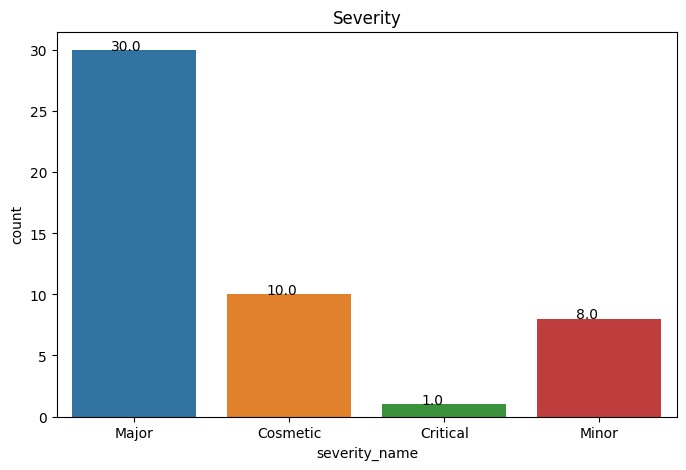

In [21]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

# Classification Rerport

In [22]:
def make_classification_report(dfResult):
    print(dfResult.tail())
    className=list(set().union(list(dfResult['severity'].unique()),list(dfResult['_predict_severity'].unique())))
    actualClass=[  f'actual-{x}' for x in  className]
    predictedlClass=[  f'predcited-{x}' for x in className]

    y_true=list(dfResult['severity'])
    y_pred=list(dfResult['_predict_severity'])
    cnf_matrix = confusion_matrix(y_true,y_pred)

    # #index=actual , column=prediction
    cm_df = pd.DataFrame(cnf_matrix,
                         index = actualClass, 
                         columns = predictedlClass)
    print(cm_df)

    print(classification_report(y_true, y_pred, labels=className))

# Load Model from Directory to Predict

In [28]:
if  isLocalModel: # Window Enviroment
    PATH_FOLDER_ARTIFACTS=local_model_path   
else: # For running on Vertex AI Notebook t
    PATH_FOLDER_ARTIFACTS=gs_model_path
print(f"Load from {PATH_FOLDER_ARTIFACTS}")
model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)   
print(model.tensorflow_version)

Load from demo_model_tf
2.12.0


# Prediction by model on entire rows at once

In [29]:
if modelFile_endPoint==1 :
    pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
    pdPrediction

    # print(model.summary())

    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          # print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
        
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          print(row_dict)  

          input_tensor = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}
          predictionResult = model.predict(input_tensor)

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          
          # print(input_tensor)    
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]
    print("Predicted all data completely")


# Registry and Deploy Model to VertextAI
- https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#deploy_a_model_to_an_endpoint


## Load Model from Online EndPpint to Predict
- https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/train-and-deploy-model
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/make-prediction

# Load model from Vertext-Ai Model Registry

In [30]:
#https://console.cloud.google.com/vertex-ai/endpoints?project=pongthorn
#https://console.cloud.google.com/vertex-ai/batch-predictions?project=pongthorn

MODEL_URI =  f'projects/{projectId}/locations/{REGION}/models/{MODEL_ID}'
print(MODEL_URI)

model_reg = aiplatform.Model(MODEL_URI)

model_name=model_reg.display_name
print(model_reg.uri," - ",model_name)

projects/pongthorn/locations/asia-southeast1/models/2354195132556771328
gs://demo2-tf-incident-pongthorn/demo_model_tf  -  model-incident-tf-explainable


# Make a call to Endpoint

In [31]:
isEndpointAvaiable=False

listRequestData=[]
try:
    
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}")
                                   
    # endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
    #                                ,credentials=mycredentials)
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))

resource name: projects/780371717407/locations/asia-southeast1/endpoints/2469916532356939776


# Create Instances and feed it to endpoint to predict

# Convert to tenfor format

In [32]:
dfID=dfNewData[['id']]
dfID.reset_index(inplace=True,drop=True)
dfY=dfNewData[['severity','severity_name']]
dfY.reset_index(inplace=True,drop=True)
dfX=dfNewData.drop(columns=unUsedColtoPredict)
dfX.reset_index(inplace=True,drop=True)

In [33]:
instances = []
for index,row in dfX.iterrows():
    dict_item=row.to_dict()
    instance = {}
    for key, value in dict_item.items():
        if key in unUsedColtoPredict:
            continue
        if value is None:
            value = ""
        instance[key] = [value]
        # instance[key] = value
    instances.append(instance)

print(len(instances))
print(instances[0])

49
{'sla': ['8x5 NBD Response Time'], 'product_type': ['Server'], 'brand': ['HPE'], 'service_type': ['Incident'], 'incident_type': ['Network Adapter Failure'], 'open_to_close_hour': [109.33333333333333], 'response_to_resolved_hour': [105.18333333333334]}


# Prediction by endpoint on entire rows at once

In [34]:
predictions = endpoint.predict(instances=instances)
predictedY = np.argmax(predictions.predictions, axis=1)

dfPredictedY=pd.DataFrame(data={'_predict_severity':predictedY})

In [35]:
dfOnlinePred=pd.concat([dfID,dfPredictedY,dfY],axis=1)
dfOnlinePred.tail()

,id,_predict_severity,severity,severity_name
44,3895,0,0,Cosmetic
45,3869,2,2,Major
46,3829,2,2,Major
47,3851,2,1,Minor
48,3910,2,1,Minor


In [36]:
make_classification_report(dfOnlinePred)

      id  _predict_severity  severity severity_name
44  3895                  0         0      Cosmetic
45  3869                  2         2         Major
46  3829                  2         2         Major
47  3851                  2         1         Minor
48  3910                  2         1         Minor
          predcited-0  predcited-1  predcited-2  predcited-3
actual-0            6            0            4            0
actual-1            0            2            6            0
actual-2            2            4           24            0
actual-3            0            0            1            0
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.33      0.25      0.29         8
           2       0.69      0.80      0.74        30
           3       0.00      0.00      0.00         1

    accuracy                           0.65        49
   macro avg       0.44      0.41      0.42        49
wei

D:\ProgramData\anaconda3\envs\google_ai\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anaconda3\envs\google_ai\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anaconda3\envs\google_ai\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Get explanations

In [37]:
input_name = model.input_names
print("Model input name:", input_name)
output_name = model.output_names
print("Model output name:", output_name)

Model input name: ['open_to_close_hour', 'response_to_resolved_hour', 'sla', 'product_type', 'brand', 'service_type', 'incident_type']
Model output name: ['dense_1']


In [38]:
# https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions#interpret_explanation_results
# https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions#example_output_for_predictions_and_explanations
# https://cloud.google.com/vertex-ai/docs/tabular-data/classification-explanations


listExplainModel=[]
def explain_model( instanceList):

    response = endpoint.explain(instances=instanceList, parameters={})

    for explanation in response.explanations:
        # print("Explanation")
        # Feature attributions.
        attributions = explanation.attributions
        item={}
        for attribution in attributions:
            item["baseline_output"]=attribution.baseline_output_value
            item["instance_output"]=attribution.instance_output_value
            item["approx_error"]=attribution.approximation_error
            item["baseline_output"]=attribution.baseline_output_value
            sum_feat=0;
            for name in input_name:
              feat_value= attribution.feature_attributions[name][0]
              sum_feat=sum_feat+feat_value
              # print(f"  {name} :{feat_value}")
              item[name]=feat_value
            # print(f"  The sum of all of the feature importance values(instance-baseline) = {sum_feat}")
            item["sum_feat_imp"]=sum_feat
        listExplainModel.append(item)   
        

explain_model(instances)

In [39]:
dfExplainModelResult=pd.DataFrame(data=listExplainModel)
dfExplainModelResult

,baseline_output,instance_output,approx_error,open_to_close_hour,response_to_resolved_hour,sla,product_type,brand,service_type,incident_type,sum_feat_imp
0,0.455226,0.875236,0.000163,-0.011487,0.007266,0.000000,0.108847,-0.003739,0.181819,0.137303,0.420010
1,0.455226,0.572955,0.000424,-0.083601,0.068959,-0.011655,-0.023359,0.018116,0.234868,-0.085598,0.117729
2,0.455226,0.849298,0.000219,-0.000532,0.000134,0.006608,0.052015,-0.008414,0.208040,0.136219,0.394071
3,0.455226,0.689012,0.000354,-0.003176,0.000332,0.050547,-0.105713,0.019525,0.226890,0.045382,0.233786
4,0.455226,0.818939,0.000311,-0.000656,0.000111,0.031692,0.066685,0.013763,0.199770,0.052348,0.363713
5,0.455226,0.789972,0.000480,-0.000610,0.000242,0.041520,-0.005723,0.017088,0.242299,0.039930,0.334746
6,0.455226,0.770843,0.000288,-0.000031,0.000023,0.079120,0.008337,-0.051687,0.179627,0.100229,0.315616
7,0.289242,0.590222,0.000329,0.009877,-0.008401,0.198501,0.102083,0.050703,-0.097215,0.045431,0.300980
8,0.455226,0.776530,0.000284,-0.007018,0.002092,-0.105591,0.175477,-0.007344,0.201377,0.062312,0.321304
9,0.455226,0.746194,0.000269,-0.070287,0.028585,-0.137180,0.157363,0.145309,0.222949,-0.055771,0.290968


In [40]:
dfABC=dfExplainModelResult[input_name].sum().to_frame().T
dfABC['dataset']=table_id
dfABC=dfABC.set_index('dataset')
dfABC

,open_to_close_hour,response_to_resolved_hour,sla,product_type,brand,service_type,incident_type
dataset,,,,,,,
new_incident,-0.599745,0.373454,-0.456459,2.962502,1.645045,8.990966,2.759756


In [42]:
# writer = pd.ExcelWriter(f'{table_id}_{model_name}_exp.xlsx')
# for i, dataframe in enumerate([dfExplainModelResult,dfABC]):
#     dataframe.to_excel(writer, sheet_name=f'Sheet{i + 1}')
# writer.save()

# Prediction individual row

In [113]:
# if modelFile_endPoint==2 and isEndpointAvaiable==True :

#     for data in dfNewData.to_dict(orient="records"):
#         incident_id=data['id']
#         severity=data['severity']
#         severity_name=data['severity_name']
#         # convert dict to tf format
#         request_data = {key : [value] for key,value in data.items() }
#         for key_removed in unUsedColtoPredict:
#            request_data.pop(key_removed)
#         listRequestData.append(request_data)
#         print(request_data)

#         response = endpoint.predict([request_data])
#         y_predicted = np.argmax(response.predictions, axis=1)
#         predictionResult=response[0][0]
#         print(predictionResult)
#         print(y_predicted)

#         pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
#         print("======================================================================================")

#     dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
#     dfPredictData=dfPredictData.drop(columns=['_id'])
#     dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
# else:
#      print("No endpoint to predict  as online predction")     